In [10]:
# Importaning libraries
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [11]:
# Parameters taken from fit-gLV-sat-all-Md3 of PM3 fit from pacman paper

uEc_c = 0.033328281132065346 # Ec control growth rate
uEc = 0.022984 # Ec producing bacteriocin growth rate 
uEf = 0.0363320961794854  # Ef growth rate

M11 = 0.03872987667387545# Ec -> Ec Normal One
M22 = 0.0888612551920666 # Ef -> Ef
M12 = 0.0493339883772232 # Ef -> Ec

M21_EntA = 0.0222552935928312 # EcEntA -> Ef              
M21_EntB = 0.0241836699300289 # EcEntB -> Ef              
M21_EntAB = 0.02403055087682115 # EcEntAB -> Ef            

Ks_EntA = 0.00121512703046095 # Half Maximum EntA
Ks_EntB = 0.292047702641047 # Half Maximum EntB
Ks_EntAB = 0.015223212927133401 # Half Maximum EntAB

# Saturated Lotka Volterra Model

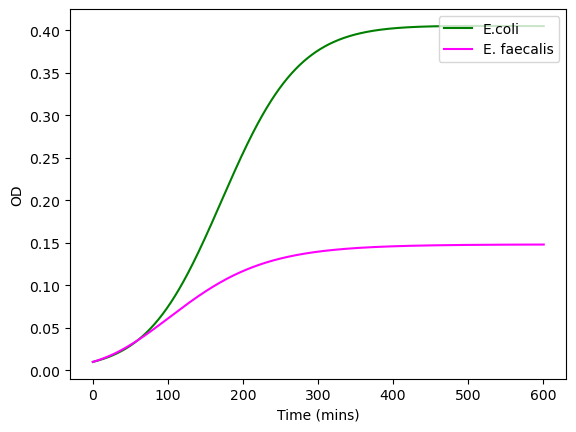

In [12]:
""" 
capturing bacteriocin action on E. faecalis.
Saturated as the population of E. coli (the predator) increases, 
the effect of bacteriocins on E. faecalis (the prey) may become saturated
"""

def lotka_volterra_saturated(X, t, uEc, uEf, M11, M22, M12, M21_EntA, Ks_EntA):
    x1, x2 = X
    dx1_dt = x1*uEc - x1*M11*x1 - x1*M12*x2
    dx2_dt = x2*uEf - x2*M22*x2-(x2*M21_EntA*x1/(Ks_EntA+x1))               
    return(np.array([dx1_dt, dx2_dt]))


# Initial conditions
x1_initial_condition = 0.01  # IC of E. Coli
x2_initial_condition = 0.01  # IC of E. Faecalis


t = np.linspace(0, 601, 1000) # 10 hours

args = (uEc, uEf, M11, M22, M12, M21_EntAB, Ks_EntAB)

initial_conditions = [x1_initial_condition, x2_initial_condition]

# Solving the system of differential equations
solution = odeint(lotka_volterra_saturated, initial_conditions, t, args=args)

# Separating the solutions for each species
x1, x2 = solution.T

# plotting interaction
plt.plot(t, x1, color = "green", label = "E.coli")
plt.plot(t, x2, color = "magenta", label = "E. faecalis")
plt.legend(loc = "upper right")
plt.xlabel("Time (mins)")
plt.ylabel("OD")
plt.show()


# Heatmap Visualization

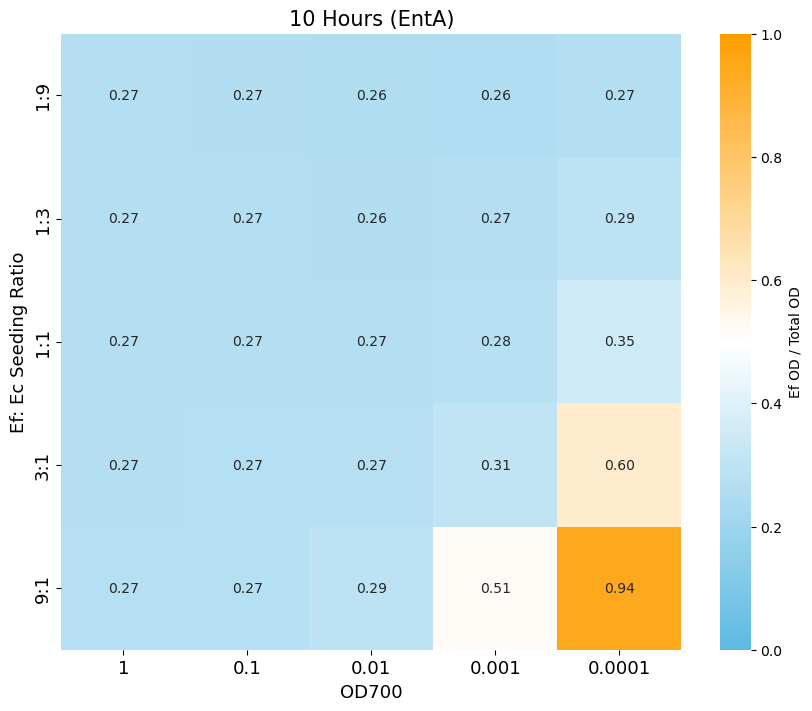

In [14]:
# Represent the ratios of E.f and E.c 
seeding_ratios = [(1, 9), (1, 3), (1, 1), (3, 1), (9, 1)]

# Contains initial densities of E.c (x1)
# Could be for either x1 or x2 as the other species is calculated based off the initial condition of the other...
x1_initial_conditions = [1, 0.1, 0.01, 0.001, 0.0001]

# DataFrame to store the results
df_final_populations = pd.DataFrame(index=["1:9", "1:3", "1:1", "3:1", "9:1"], columns=["1", "0.1", "0.01", "0.001", "0.0001"])

# Calculate the final populations and Ef OD / Total OD for each seeding ratio and initial density
for i, (ratio_ef, ratio_ec) in enumerate(seeding_ratios): 
    for j, initial_density in enumerate(x1_initial_conditions):
        
        x1_initial = initial_density * ratio_ec / (ratio_ec + ratio_ef)
        x2_initial = initial_density * ratio_ef / (ratio_ec + ratio_ef)
        
        initial_conditions = [x1_initial, x2_initial]
        args = (uEc, uEf, M11, M22, M12, M21_EntAB, Ks_EntAB)
        
        # Simulate the system
        solution = odeint(lotka_volterra_saturated, initial_conditions, t, args=args)
        x1, x2 = solution.T
        
        # Ef OD/Total OD = Dividing E.f by E.f + E.coli 
        # accesses the last element of LV results i.e. final OD conc.
        ef_od_over_total_od = x2[-1] / (x1[-1] + x2[-1])
        
        # Storing result in the df
        df_final_populations.iloc[i, j] = ef_od_over_total_od


# Converting df to floats for plotting
df_final_populations = df_final_populations.astype(float)


# Defining min and max for color scale so they remain consistent across different runs
vmin = 0
vmax = 1 

# Creating a color scheme to match Pacman Paper
colors = ["#5EB9E2","white", "#FE9E00"]  # Orange to Blue
n_bins = 1000000  # High bins for smoother gradient
cmap = LinearSegmentedColormap.from_list(name='Custom', colors=colors, N=n_bins)


# Plotting heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_final_populations, annot=True, fmt=".2f", cmap=cmap, cbar_kws={'label': 'Ef OD / Total OD'}, vmin=vmin, vmax=vmax)

plt.tick_params(labelsize=13)
plt.title('10 Hours (EntA)', size=15)
plt.xlabel('OD700', size=13)
plt.ylabel('Ef: Ec Seeding Ratio', size=13)
plt.show()

# ColorScheme 
# Orange = FF9F00
# Blue = 5EB9E2

